In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import load_img, img_to_array
from tqdm.notebook import tqdm
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
# Evaluation metrics
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from collections import defaultdict

2025-08-26 12:33:22.590871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756211602.614015 1553995 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756211602.621018 1553995 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
image_path = '/kaggle/input/flickr8k/Images'

In [3]:
with open('/kaggle/input/flickr8k-prepared-data/tokenizer.pkl', "rb") as f:
    tokenizer = pickle.load(f)

with open('/kaggle/input/flickr8k-prepared-data/features.pkl', "rb") as f:
    features = pickle.load(f)

with open('/kaggle/input/flickr-8k-prepared-model/config.pkl', "rb") as f:
    config = pickle.load(f)
max_length = config['max_length']
vocab_size = config['vocab_size']

data = pd.read_pickle('/kaggle/input/flickr8k-prepared-data/captions.pkl')
model = load_model('/kaggle/input/flickr-8k-prepared-model/model.keras')

# Load test set
test = pd.read_pickle('/kaggle/input/flickr-8k-prepared-model/test.pkl')

print("All files loaded successfully.")

I0000 00:00:1756211606.478093 1553995 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756211606.478835 1553995 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


All files loaded successfully.


In [4]:
# Map index to word
index_word = {v: k for k, v in tokenizer.word_index.items()}

def word_for_id(integer, tokenizer):
    return index_word.get(integer, None)


In [5]:
def greedy_search(model, photo, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text


In [6]:
def beam_search(model, photo, tokenizer, max_length, beam_width=3):
    start = [tokenizer.word_index['startseq']]
    sequences = [[start, 0.0]]  # [sequence, score]

    while len(sequences[0][0]) < max_length:
        all_candidates = []
        for seq, score in sequences:
            if seq[-1] == tokenizer.word_index['endseq']:
                # don't expand further, just keep sequence
                all_candidates.append((seq, score))
                continue

            sequence = pad_sequences([seq], maxlen=max_length)
            yhat = model.predict([photo, sequence], verbose=0)
            yhat = np.log(yhat[0] + 1e-10)  # log-probs for stability

            # take top beam_width predictions
            top_idxs = np.argsort(yhat)[-beam_width:]
            for idx in top_idxs:
                candidate = seq + [idx]
                candidate_score = score - yhat[idx]
                all_candidates.append((candidate, candidate_score))

        # order by score
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]

        # check if all beams ended
        if all(seq[-1] == tokenizer.word_index['endseq'] for seq, _ in sequences):
            break

    # best sequence
    best_seq = sequences[0][0]

    # convert to words
    words = [word for idx in best_seq for word, index in tokenizer.word_index.items() if index == idx]
    final_caption = ' '.join(words)

    # clean up start/end
    final_caption = final_caption.replace('startseq', '').replace('endseq', '').strip()
    return "startseq " + final_caption + " endseq"


In [7]:
def evaluate_model(model, captions, features, tokenizer, max_length, method="greedy", beam_width=3):
    """
    Evaluate captioning model using greedy or beam search.
    Computes BLEU-1, BLEU-2, BLEU-3, BLEU-4, METEOR, and CIDEr scores.
    """
    actual, predicted = [], []
    meteor_scores = []

    # Use tqdm to track progress
    for img in tqdm(captions['image'].unique(), desc="Evaluating"):
        # Generate prediction
        if method == "greedy":
            yhat = greedy_search(model, features[img], tokenizer, max_length)
        else:
            yhat = beam_search(model, features[img], tokenizer, max_length, beam_width)

        # Clean up predicted caption
        yhat_tokens = yhat.split()

        # Get references (tokenized)
        references = [ref.split() for ref in captions[captions['image'] == img]['caption'].tolist()]

        actual.append(references)
        predicted.append(yhat_tokens)

        # METEOR (tokenized input is required)
        meteor_scores.append(
            np.mean([meteor_score([ref], yhat_tokens) for ref in references])
        )

    # BLEU scores with smoothing
    smooth = SmoothingFunction().method1
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smooth)
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
    bleu3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth)
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)

    results = {
        "BLEU-1": bleu1,
        "BLEU-2": bleu2,
        "BLEU-3": bleu3,
        "BLEU-4": bleu4,
        "METEOR": np.mean(meteor_scores)
    }

    return results


In [8]:
results = {}

print("Evaluating with Greedy Search...")
results["Greedy"] = evaluate_model(model, test, features, tokenizer, max_length, method="greedy")

for bw in range(2, 6):
    print(f"\nEvaluating with Beam Search (beam_width={bw})...")
    results[f"Beam-{bw}"] = evaluate_model(model, test, features, tokenizer, max_length, method="beam", beam_width=bw)

# Tabular Results
results_df = pd.DataFrame(results).T
display(results_df)

Evaluating with Greedy Search...


Evaluating: 100%|██████████| 1214/1214 [15:13<00:00,  1.33it/s]



Evaluating with Beam Search (beam_width=2)...


Evaluating: 100%|██████████| 1214/1214 [30:05<00:00,  1.49s/it]



Evaluating with Beam Search (beam_width=3)...


Evaluating: 100%|██████████| 1214/1214 [45:11<00:00,  2.23s/it]



Evaluating with Beam Search (beam_width=4)...


Evaluating: 100%|██████████| 1214/1214 [1:00:09<00:00,  2.97s/it]



Evaluating with Beam Search (beam_width=5)...


Evaluating: 100%|██████████| 1214/1214 [1:14:41<00:00,  3.69s/it]


,BLEU-1,BLEU-2,BLEU-3,BLEU-4,METEOR
Greedy,0.608628,0.384339,0.254727,0.157586,0.283080
Beam-2,0.626665,0.405218,0.274826,0.176004,0.284912
Beam-3,0.627861,0.408444,0.279671,0.181178,0.281044
Beam-4,0.630395,0.411336,0.281193,0.182237,0.278754
Beam-5,0.629139,0.407188,0.276754,0.177975,0.274114


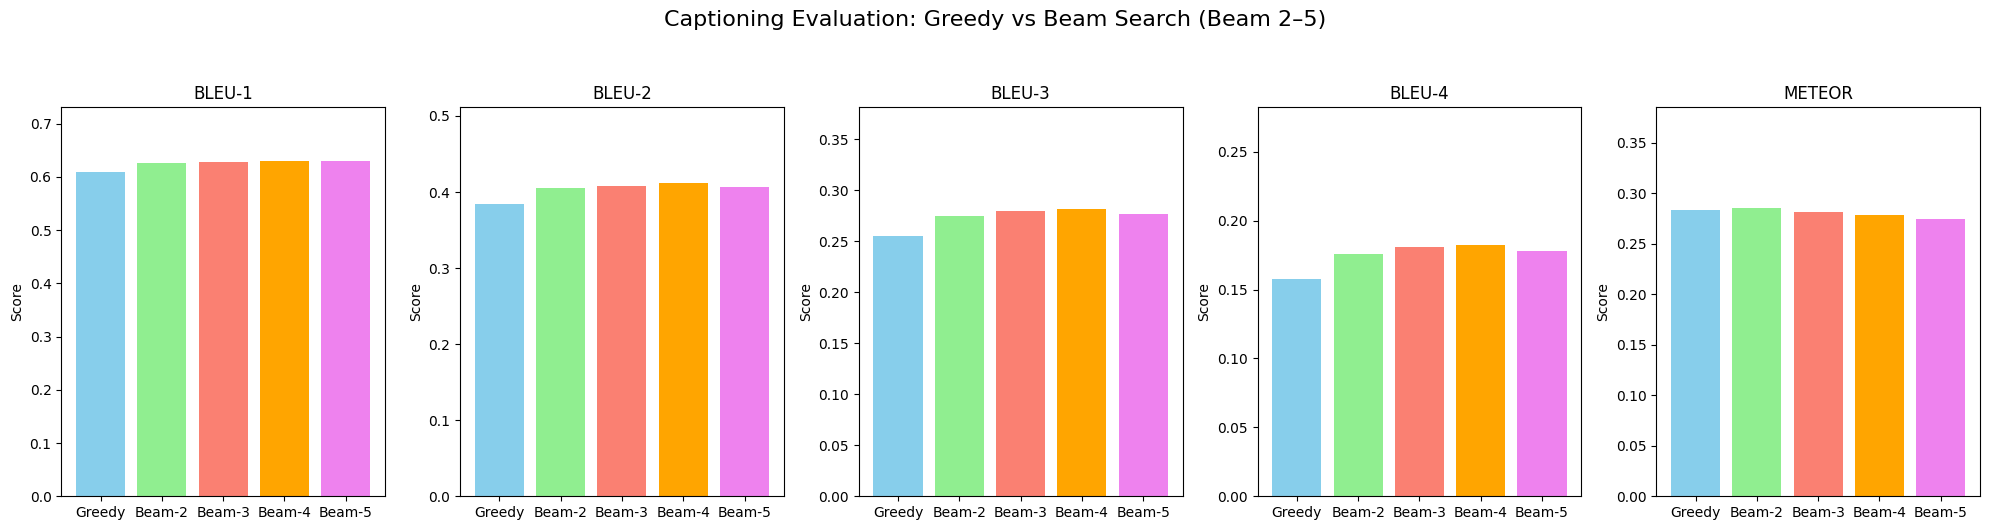

In [9]:
# Metrics to plot
metrics = ["BLEU-1", "BLEU-2", "BLEU-3", "BLEU-4", "METEOR"]
# Prepare data
labels = list(results.keys())  # ["Greedy", "Beam-2", "Beam-3", "Beam-4", "Beam-5"]

# Create subplots for each metric
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))

for i, metric in enumerate(metrics):
    scores = [results[label][metric] for label in labels]
    axes[i].bar(labels, scores, color=['skyblue','lightgreen','salmon','orange','violet'])
    axes[i].set_title(metric)
    axes[i].set_ylabel("Score")
    axes[i].set_ylim(0, max(scores) + 0.1)

plt.suptitle("Captioning Evaluation: Greedy vs Beam Search (Beam 2–5)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

Best Beam Width (based on average score): 4
Image: 405534893_2d0f3b0147.jpg
Greedy Caption: startseq man in blue shirt is climbing rock endseq
Beam-4 Caption: startseq man is rock climbing endseq


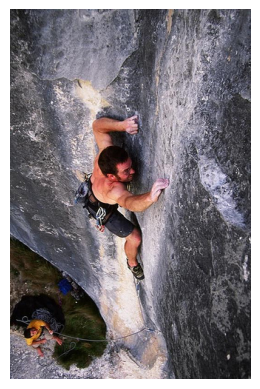

In [10]:
# --- Step 1: Find best beam width (based on average of BLEU-1, BLEU-2, BLEU-3, BLEU-4, METEOR) ---
beam_scores = {k: v for k, v in results.items() if "Beam" in k}

def average_metrics(score_dict):
    metrics = ["BLEU-1", "BLEU-2", "BLEU-3", "BLEU-4", "METEOR"]
    return sum(score_dict[m] for m in metrics) / len(metrics)

best_beam = max(beam_scores, key=lambda x: average_metrics(beam_scores[x]))
best_beam_width = int(best_beam.split("-")[1])
print(f"Best Beam Width (based on average score): {best_beam_width}")

# --- Step 2: Pick random test image ---
sample = random.choice(test['image'].unique())
photo = features[sample]

# --- Step 3: Generate captions ---
greedy_caption = greedy_search(model, photo, tokenizer, max_length)
beam_caption = beam_search(model, photo, tokenizer, max_length, beam_width=best_beam_width)

# --- Step 4: Display ---
print("Image:", sample)
print("Greedy Caption:", greedy_caption)
print(f"Beam-{best_beam_width} Caption:", beam_caption)

plt.imshow(load_img(f"/kaggle/input/flickr8k/Images/{sample}"))
plt.axis("off")
plt.show()